# IMPORT LIBRARY

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import os
from sklearn.metrics import confusion_matrix
from textblob import TextBlob
from nltk.stem import PorterStemmer
from textblob import Word
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import sklearn.feature_extraction.text as text
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from io import StringIO
import seaborn as sns

In [2]:
%%HTML
    <style type="text/css">
        table.dataframe td, table.dataframe th {
            border-style: solid;
        }
</style>

# READ DATA

In [3]:
Data = pd.read_csv("DATA/Consumer_Complaints.csv", encoding='latin-1')
Data.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,03/21/2017,Credit reporting,NaN,Incorrect information on credit report,Information is not mine,NaN,Company has responded to the consumer and the ...,EXPERIAN DELAWARE GP,TX,77075,Older American,NaN,Phone,03/21/2017,Closed with non-monetary relief,Yes,No,2397100
1,04/19/2017,Debt collection,"Other (i.e. phone, health club, etc.)",Disclosure verification of debt,Not disclosed as an attempt to collect,NaN,NaN,"Security Credit Services, LLC",IL,60643,NaN,NaN,Web,04/20/2017,Closed with explanation,Yes,No,2441777
2,04/19/2017,Credit card,NaN,Other,NaN,NaN,Company has responded to the consumer and the ...,"CITIBANK, N.A.",IL,62025,NaN,NaN,Referral,04/20/2017,Closed with explanation,Yes,No,2441830
3,04/14/2017,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,Company believes it acted appropriately as aut...,"Shellpoint Partners, LLC",CA,90305,NaN,NaN,Referral,04/14/2017,Closed with explanation,Yes,No,2436165
4,04/19/2017,Credit card,NaN,Credit determination,NaN,NaN,Company has responded to the consumer and the ...,U.S. BANCORP,LA,70571,NaN,NaN,Postal mail,04/21/2017,Closed with explanation,Yes,No,2441726


# Statistical Analysis

In [4]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777959 entries, 0 to 777958
Data columns (total 18 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   Date received                 777959 non-null  object
 1   Product                       777959 non-null  object
 2   Sub-product                   542822 non-null  object
 3   Issue                         777959 non-null  object
 4   Sub-issue                     320986 non-null  object
 5   Consumer complaint narrative  157865 non-null  object
 6   Company public response       197884 non-null  object
 7   Company                       777959 non-null  object
 8   State                         772056 non-null  object
 9   ZIP code                      772001 non-null  object
 10  Tags                          109264 non-null  object
 11  Consumer consent provided?    288311 non-null  object
 12  Submitted via                 777959 non-null  object
 13 

# Select Columns And Rows

In [5]:
Data = Data[['Product', 'Consumer complaint narrative']]
Data = Data[pd.notnull(Data['Consumer complaint narrative'])]

In [6]:
Data.head()

,Product,Consumer complaint narrative
9,Mortgage,Started the refinance of home mortgage process...
35,Bank account or service,My wife and I visited the Chase Bank branch at...
39,Student loan,The service representative was harsh and not l...
46,Bank account or service,I have documentation that shows that US Bank w...
54,Credit reporting,Experian reporting of XXXX XXXX reflects a for...


# Product Feature Factorization

In [7]:
Data['category_id'] = Data['Product'].factorize()[0]
Data.head()

,Product,Consumer complaint narrative,category_id
9,Mortgage,Started the refinance of home mortgage process...,0
35,Bank account or service,My wife and I visited the Chase Bank branch at...,1
39,Student loan,The service representative was harsh and not l...,2
46,Bank account or service,I have documentation that shows that US Bank w...,1
54,Credit reporting,Experian reporting of XXXX XXXX reflects a for...,3


# Investigate the distribution of the products complained of

In [8]:
Data.groupby('Product')['Consumer complaint narrative'].count() #.mean() / .median()

Product
Bank account or service    14500
Consumer Loan               9029
Credit card                18276
Credit reporting           30319
Debt collection            38741
Money transfers             1437
Mortgage                   32000
Other financial service      272
Payday loan                 1695
Prepaid card                1404
Student loan               10176
Virtual currency              16
Name: Consumer complaint narrative, dtype: int64

# Draw The Above Code Diagram

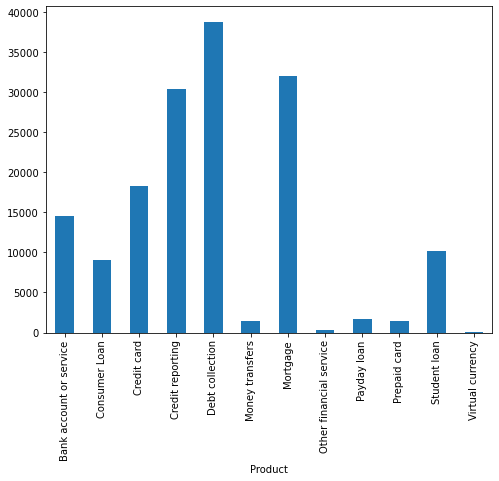

In [9]:
fig = plt.figure(figsize=(8,6))
Data.groupby('Product')['Consumer complaint narrative'].count().plot.bar(ylim=0)
plt.show()

# Train Test Split

In [10]:
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(Data['Consumer complaint narrative'], Data['Product'])

print(f"shape of train_x: {train_x.shape}")
print(f"shape of valid_x: {valid_x.shape}")
print(f"shape of train_y: {train_y.shape}")
print(f"shape of valid_y: {valid_y.shape}")

shape of train_x: (118398,)
shape of valid_x: (39467,)
shape of train_y: (118398,)
shape of valid_y: (39467,)


# Generate Up To 5000 Features Using Vectors

In [11]:
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(Data['Consumer complaint narrative'])
xtrain_tfidf = tfidf_vect.transform(train_x)
xvalid_tfidf = tfidf_vect.transform(valid_x)

# Create Model

In [12]:
model = linear_model.LogisticRegression().fit(xtrain_tfidf, train_y)

C:\Users\DaryaSystem\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [13]:
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,intercept_scaling=1, max_iter=100, multi_class='ovr',
                   n_jobs=1, penalty='l2', random_state=None, solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(multi_class='ovr', n_jobs=1, solver='liblinear')

# Model Accuracy

In [14]:
accuracy = metrics.accuracy_score(model.predict(xvalid_tfidf), valid_y)
print ("Accuracy: ", accuracy)

Accuracy:  0.8557275698684977


# Classification Report

In [15]:
print(metrics.classification_report(valid_y, model.predict(xvalid_tfidf),target_names=Data['Product'].unique()))

                         precision    recall  f1-score   support

               Mortgage       0.82      0.82      0.82      3628
Bank account or service       0.77      0.62      0.69      2201
           Student loan       0.83      0.83      0.83      4668
       Credit reporting       0.87      0.87      0.87      7513
            Credit card       0.82      0.89      0.86      9621
        Debt collection       0.75      0.54      0.63       371
          Consumer Loan       0.93      0.95      0.94      8016
Other financial service       0.00      0.00      0.00        73
        Money transfers       0.69      0.31      0.43       427
           Prepaid card       0.84      0.56      0.67       345
            Payday loan       0.91      0.88      0.89      2600
       Virtual currency       0.00      0.00      0.00         4

               accuracy                           0.86     39467
              macro avg       0.69      0.61      0.64     39467
           weighted avg

C:\Users\DaryaSystem\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Confusion Matrix

In [17]:
conf_mat = confusion_matrix(valid_y, model.predict(xvalid_tfidf))

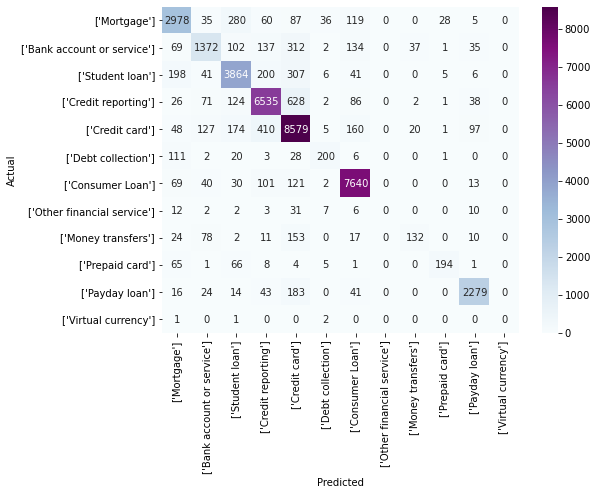

In [18]:
category_id_df = Data[['Product', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            cmap="BuPu",
            xticklabels=category_id_df[['Product']].values,
            yticklabels=category_id_df[['Product']].values)

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Sample Of Predict

In [19]:
# مثال پیش بینی
texts = ["how much I have to wait to transfer money? This is really bad"]         
text_features = tfidf_vect.transform(texts)
predictions = model.predict(text_features)

print(texts)
print(" - Predicted as: '{}'".format(id_to_category[predictions[0]]))

['how much I have to wait to transfer money? This is really bad']
 - Predicted as: 'Debt collection'
